
# Analyse du changement de surface d'eau entre les images NDWI d'un drone et de WorldView

Ce script Python utilise des données NDWI (Normalized Difference Water Index) provenant de deux sources : un drone et l'imagerie satellitaire WorldView. L'objectif est de comparer les zones d'eau identifiées à partir des images des deux sources et d'analyser les changements de surface d'eau entre ces périodes.

## Étapes principales :
1. **Lecture des données NDWI** : Les fichiers NDWI sont lus à partir des images du drone et de WorldView.
2. **Reprojection et rééchantillonnage** : L'image NDWI WorldView est reprojetée pour correspondre aux dimensions et au système de coordonnées du drone.
3. **Création des masques d'eau** : Des masques d'eau sont créés à partir des images NDWI en appliquant un seuil sur les valeurs de NDWI.
4. **Combinaison des masques** : Les masques d'eau des deux sources sont combinés pour faciliter la comparaison.
5. **Calcul des statistiques** : La surface d'eau est calculée pour les deux sources, ainsi que les changements nets et le pourcentage de variation.
6. **Visualisation des résultats** : Des cartes NDWI pour le drone et WorldView, ainsi qu'une carte combinée des masques d'eau, sont générées et affichées.
    
## Visualisation :
Les cartes affichées permettent de voir la distribution des surfaces d'eau selon les deux sources et de comprendre les différences éventuelles.
    
## Résultats :
Les statistiques finales fournissent une estimation de la différence de surface d'eau et du pourcentage de changement entre les deux périodes analysées.


In [1]:

import rasterio 
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma # type: ignore
from matplotlib.colors import ListedColormap # type: ignore
from matplotlib.patches import Patch


In [2]:

def create_water_mask(ndwi, threshold):
    return (ndwi > threshold).astype(np.uint8)

def create_combined_mask(drone_mask, wv_mask):
    combined_mask = (drone_mask * 2) + wv_mask
    return combined_mask


In [3]:

# Chemins des fichiers NDWI
drone_ndwi_path = r"D:\UQTR\Automne 2024\Ouest\riviere\mavic_ndwi.tif"
wv_ndwi_path = r"D:\UQTR\Automne 2024\Ouest\riviere\worldview_2_ndwi.tif"

# Lecture du raster NDWI du drone
with rasterio.open(drone_ndwi_path) as src:
    drone_ndwi = src.read(1).astype(np.float32)
    drone_crs = src.crs
    drone_transform = src.transform
    drone_width = src.width
    drone_height = src.height
    profile = src.profile

# Lecture du raster NDWI WorldView
with rasterio.open(wv_ndwi_path) as src:
    wv_ndwi = src.read(1).astype(np.float32)
    wv_crs = src.crs
    wv_transform = src.transform

# Reprojection et rééchantillonnage du raster NDWI WorldView
wv_ndwi_reprojected = np.empty((drone_height, drone_width), dtype=np.float32)

reproject(
    source=wv_ndwi,
    destination=wv_ndwi_reprojected,
    src_transform=wv_transform,
    src_crs=wv_crs,
    dst_transform=drone_transform,
    dst_crs=drone_crs,
    resampling=Resampling.bilinear
)

wv_ndwi = wv_ndwi_reprojected


In [4]:

# Nettoyer les données
drone_ndwi = np.nan_to_num(drone_ndwi, nan=0.0, posinf=0.0, neginf=0.0)
wv_ndwi = np.nan_to_num(wv_ndwi, nan=0.0, posinf=0.0, neginf=0.0)

# Création des masques d'eau
drone_threshold = 0.17  # Ajuster selon vos données
wv_threshold = 0.40     # Ajuster selon vos données
drone_water_mask = create_water_mask(drone_ndwi, drone_threshold)
wv_water_mask = create_water_mask(wv_ndwi, wv_threshold)

# Création du masque combiné
combined_mask = create_combined_mask(drone_water_mask, wv_water_mask)


In [5]:

profile.update(dtype=rasterio.uint8, count=1, nodata=255)
with rasterio.open('combined_water_mask.tif', 'w', **profile) as dst:
    dst.write(combined_mask, 1)


In [6]:

pixel_area = abs(drone_transform.a * drone_transform.e)

drone_water_pixels = np.sum(drone_water_mask == 1)
wv_water_pixels = np.sum(wv_water_mask == 1)

drone_water_area = drone_water_pixels * pixel_area
wv_water_area = wv_water_pixels * pixel_area

net_water_change_area = drone_water_area - wv_water_area
percentage_change = (net_water_change_area / wv_water_area) * 100 if wv_water_area != 0 else 0

# Affichage des statistiques
print("=== Statistiques de l'analyse de changement d'eau ===")
print(f"Surface d'eau WorldView : {wv_water_area:.2f} m²")
print(f"Surface d'eau Drone : {drone_water_area:.2f} m²")
print(f"Changement net de surface d'eau : {net_water_change_area:.2f} m²")
print(f"Pourcentage de changement par rapport à WorldView : {percentage_change:.2f}%")


=== Statistiques de l'analyse de changement d'eau ===
Surface d'eau WorldView : 42280.21 m²
Surface d'eau Drone : 34199.89 m²
Changement net de surface d'eau : -8080.32 m²
Pourcentage de changement par rapport à WorldView : -19.11%


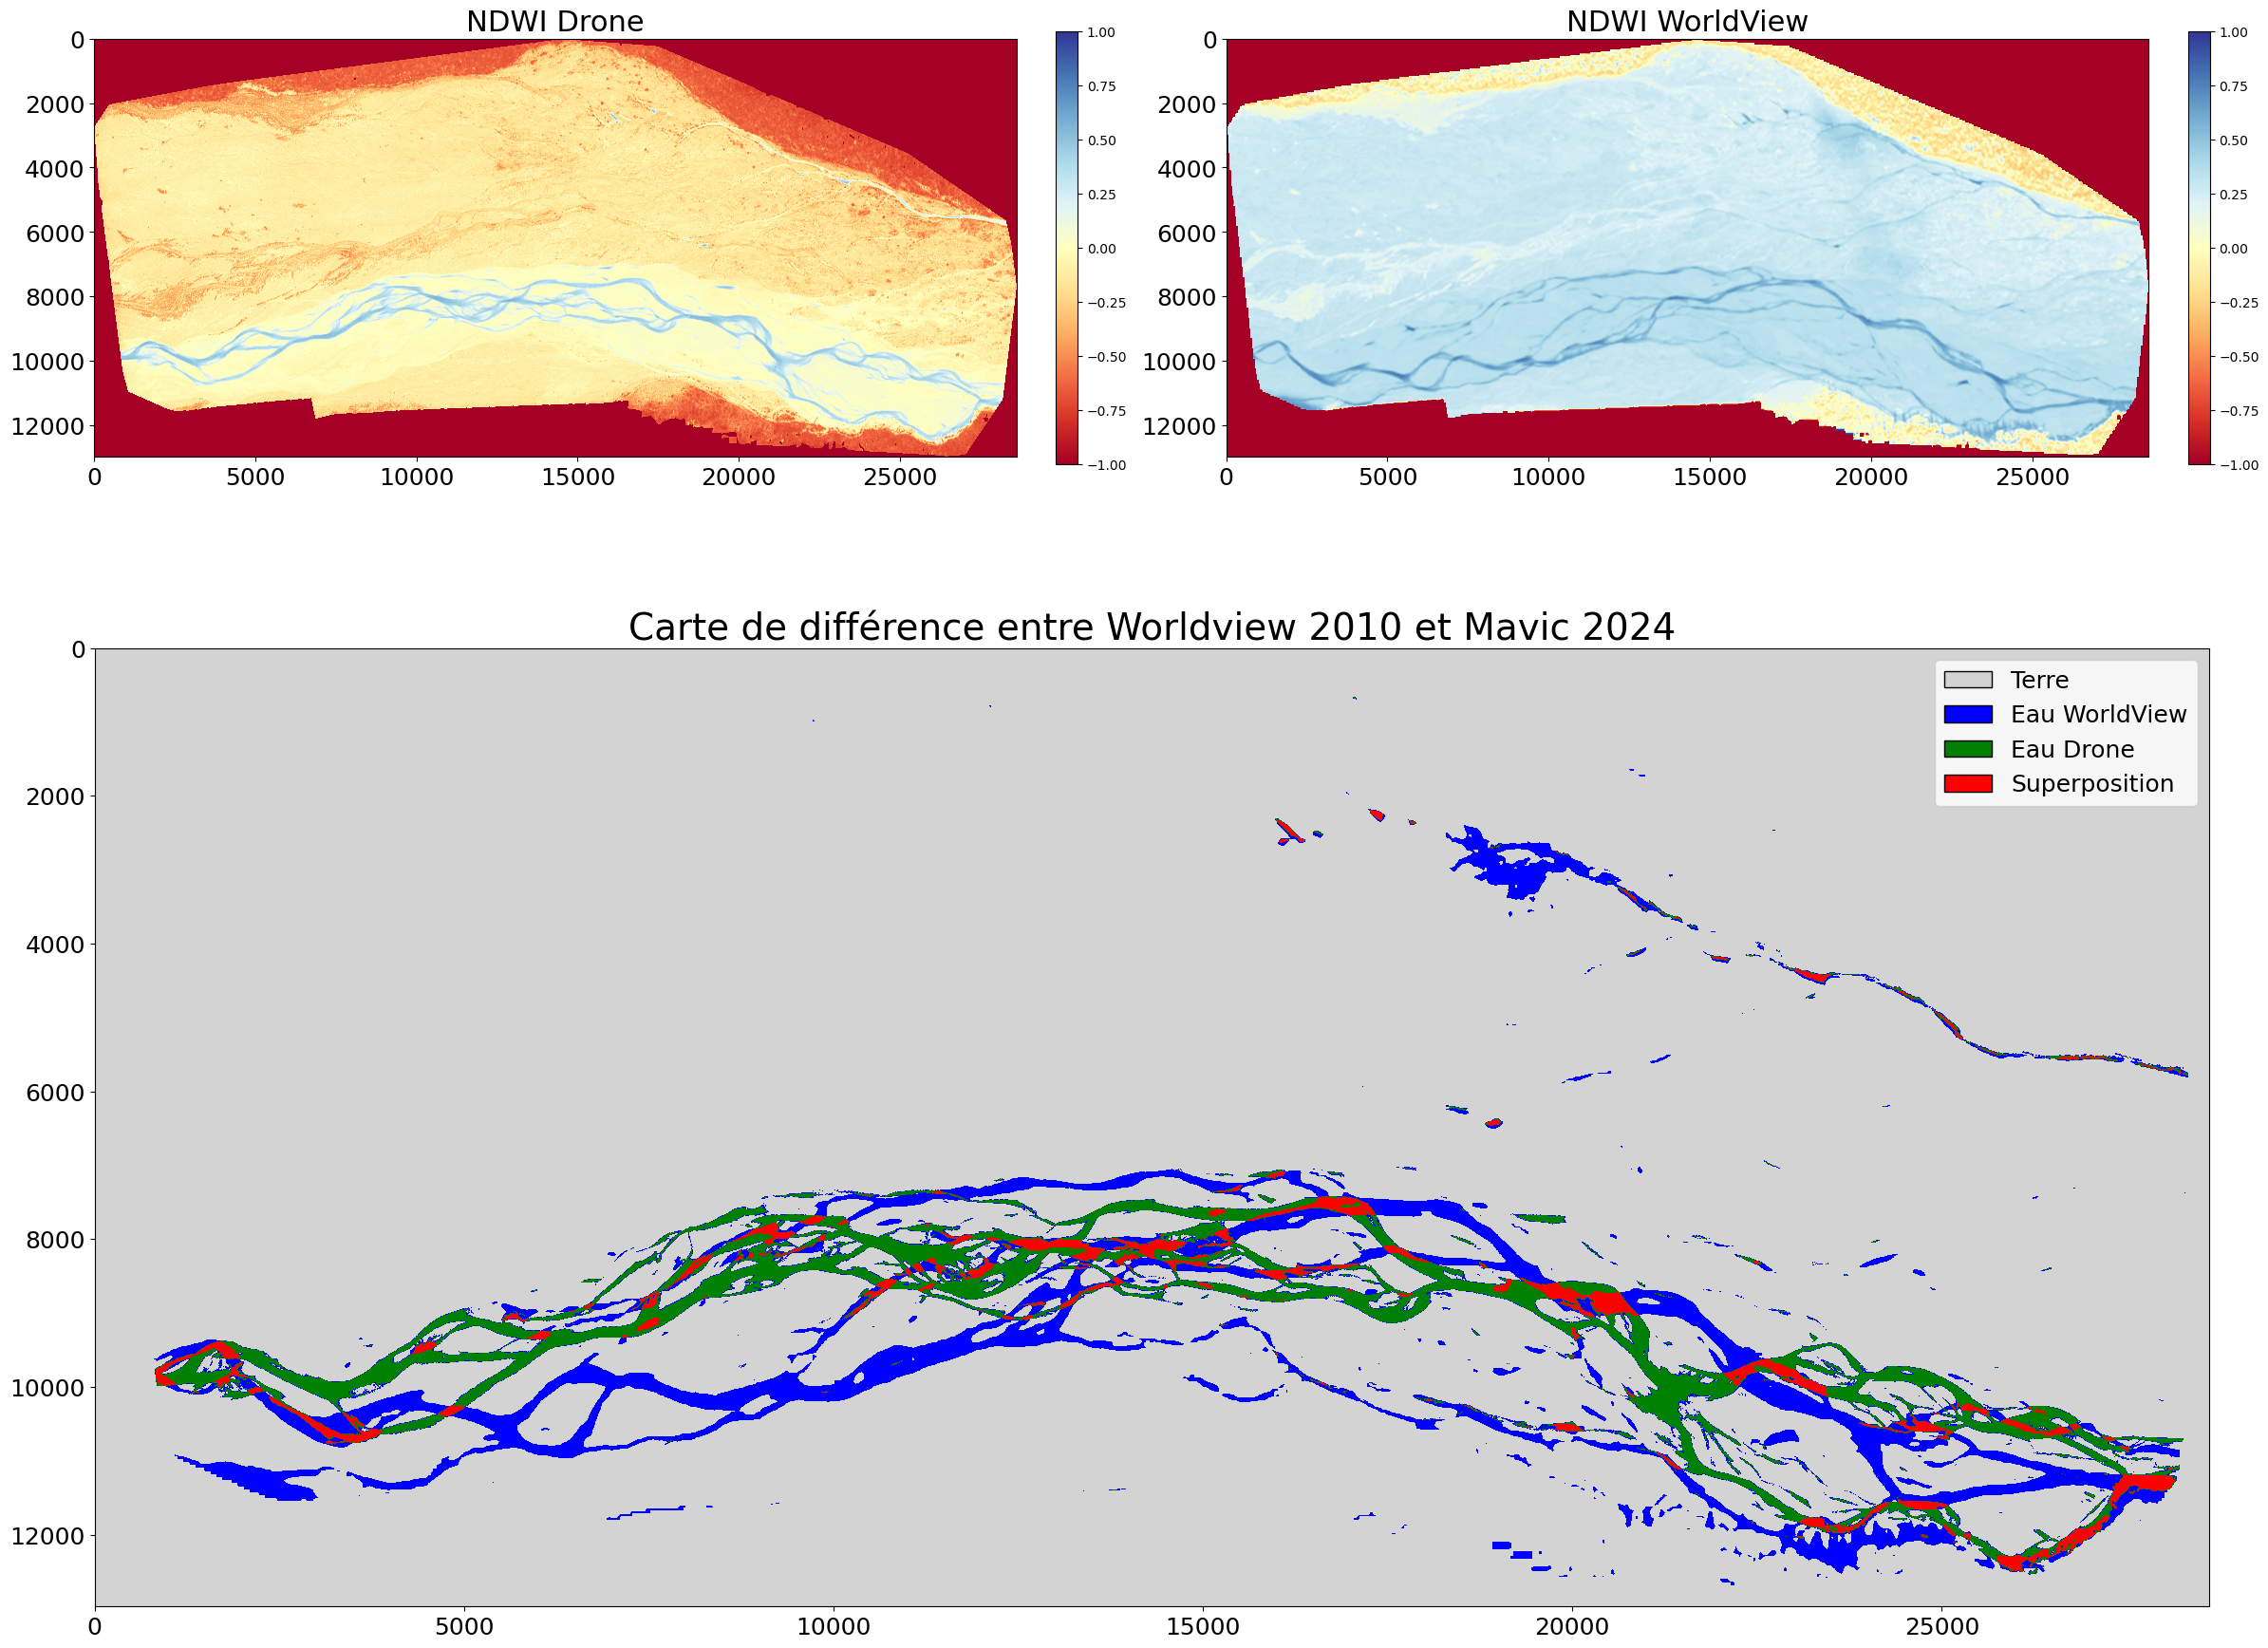

In [7]:
from matplotlib.patches import Patch

# Visualisation
fig = plt.figure(figsize=(24, 20))

# Masquer les valeurs invalides
drone_ndwi_masked = ma.masked_invalid(drone_ndwi)
wv_ndwi_masked = ma.masked_invalid(wv_ndwi)
combined_mask_masked = ma.masked_equal(combined_mask, 255)

# Définir une palette de couleurs personnalisée
cmap = ListedColormap(['lightgrey', 'blue', 'green', 'red'])
labels = ['Terre', 'Eau WorldView', 'Eau Drone', 'Superposition']

# Carte NDWI du drone
ax1 = plt.subplot2grid((2, 2), (0, 0))
im1 = ax1.imshow(drone_ndwi_masked, cmap='RdYlBu', vmin=-1, vmax=1)
ax1.set_title('NDWI Drone', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=18)
plt.colorbar(im1, ax=ax1, fraction=0.022, pad=0.04)

# Carte NDWI WorldView
ax2 = plt.subplot2grid((2, 2), (0, 1))
im2 = ax2.imshow(wv_ndwi_masked, cmap='RdYlBu', vmin=-1, vmax=1)
ax2.set_title('NDWI WorldView', fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=18)
plt.colorbar(im2, ax=ax2, fraction=0.022, pad=0.04)

# Carte combinée des masques d'eau
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
im3 = ax3.imshow(combined_mask_masked, cmap=cmap, vmin=0, vmax=3)
ax3.set_title('Carte de différence entre Worldview 2010 et Mavic 2024', fontsize=28)
ax3.tick_params(axis='both', which='major', labelsize=18)

# Création de la légende personnalisée avec police modifiée
legend_elements = [Patch(facecolor=cmap(i), edgecolor='k', label=labels[i]) for i in range(4)]
legend = ax3.legend(handles=legend_elements, loc='upper right', fontsize=18)
for text in legend.get_texts():
    text.set_fontsize(18)

plt.tight_layout()
plt.savefig('water_overlap_high_quality.png', dpi=300, bbox_inches='tight')
plt.show()
